In [1]:
from builtins import range
import os.path
import sys
import time
import json
import pickle
import time
import numpy as np
from gep import GEP
#from plot_utils import *
import collections
from imgep_utils.gep_utils import *
from imgep_utils.neural_network import PolicyNN
import gym
import gym_flowers
import imgep_utils.config as conf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import imageio
from active_goal_sampling import SAGG_RIAC

In [2]:
def get_o(obs):
    return obs[-2:]
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def run_episode(model, max_step=40):
    out = env.reset()
    state = get_o(out['observation'])
    normalized_state = scale_vector(state, np.array(input_bounds))
    nb_steps = 0
    done = False
    while not done:
        nb_steps += 1
        #print(nb_steps)
        actions = model.get_action(normalized_state.reshape(1, -1))
        out, _, done, _ = env.step(actions[0])
        state = get_o(out['observation'])
        normalized_state = scale_vector(state, np.array(input_bounds))
    return state

#PLOTTING UTILS
def region_plot_gif():
    print("Making an exploration GIF")
    filenames = []
    for i in range(len(goals)):
        if (i>nb_bt) and (i%50 == 0):  
            f, (ax0,ax1) = plt.subplots(1,2,figsize=(18,7))
            ax = [ax0,ax1]
            plot_goal_outcomes(reached_Xs[nb_bt:i], reached_Ys[nb_bt:i], goals[0:i], ax=ax[0])
            idx = 0
            cur_idx = 0
            for j in range(len(all_boxes)):
                if iterations[j] > i:
                    break
                else:
                    cur_idx = j
        #print("idx:{}".format(cur_idx))
            plot_regions(all_boxes[cur_idx], interests[cur_idx],ax=ax[1])
            f_name = "../../../graphics/gifs/scatter_{}.png".format(i)
            plt.savefig(f_name, bbox_inches='tight')
            filenames.append(f_name)
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('../../../graphics/scatter.gif', images, duration=0.3)


def plot_density(Xs,Ys):
    f, ax = plt.subplots(1,1,figsize=(7,7))
    ax.set_xlim(xmin=-20,xmax=20)
    ax.set_ylim(ymin=-20,ymax=20)
    ax.hist2d(Xs,Ys , bins=(50, 50), cmap=plt.cm.jet)
    plt.show()

def plot_goal_outcomes(Xs,Ys, goals, ax=None):
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=(7,7))
    ax.axis('equal')
    ax.set_xlim(xmin=-4,xmax=4)
    ax.set_ylim(ymin=-4,ymax=4)
    #ax.axis('equal')
    ax.plot(Xs,Ys,'ro',markersize=2, color='r', label='Agent')
    ax.plot(np.array(goals)[:,0],np.array(goals)[:,1],'ro',markersize=2, color='b', label='Agent')

def plot_regions(boxes, interests, ax=None):
    # Create figure and axes
    if ax==None:             
        f, ax = plt.subplots(1,1,figsize=(8,7))
    ax.set_xlim(xmin=-4,xmax=4)
    ax.set_ylim(ymin=-4,ymax=4)
    # Add the patch to the Axes
    for b,ints in zip(boxes,interests):
        #print(ints)
        lx,ly = unscale_vector(b.low, np.array(full_outcome_bounds))
        hx,hy = unscale_vector(b.high, np.array(full_outcome_bounds))
        c = plt.cm.jet(ints)
        rect = patches.Rectangle([lx,ly],(hx - lx),(hy - ly),linewidth=3,edgecolor='white',facecolor=c)
        ax.add_patch(rect)
        #plt.Rectangle([lx,ly],(hx - lx), (hy - ly))

    import matplotlib.colorbar as cbar
    cax, _ = cbar.make_axes(ax) 
    cb = cbar.ColorbarBase(cax, cmap=plt.cm.jet) 
    cb.set_label('Mean Competence Progress')

input_bounds: [[-4.0, 4.0], [-4.0, 4.0]]
nb_biases: 71
{'policy_nb_dims': 647, 'modules': {'mod1': {'outcome_range': array([0, 1]), 'focus_state_range': array([0, 1])}}}
2
########### Iteration # 0 ##########
regions [Box(2,), Box(2,)] all_boxes: <class 'list'>


/home/remy/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/remy/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
/home/remy/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/remy/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', o

regions [Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>
regions [Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,), Box(2,)] all_boxes: <class 'list'>


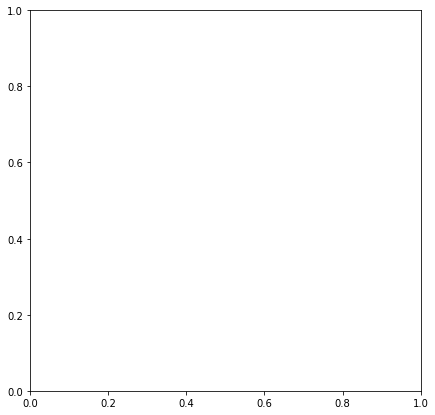

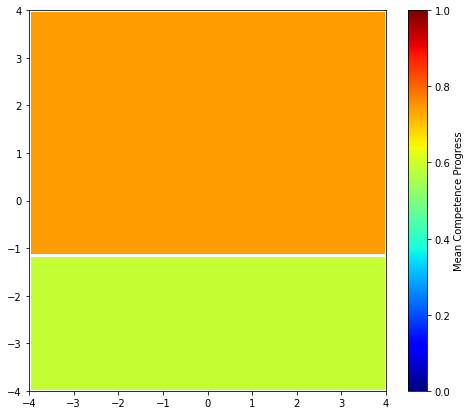

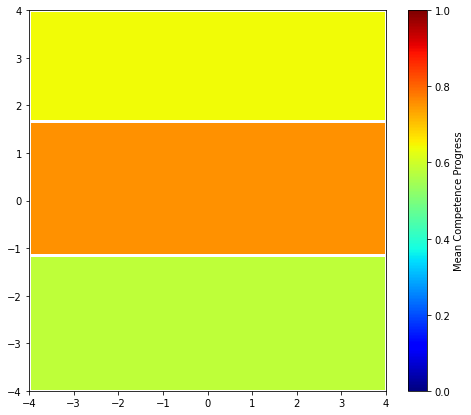

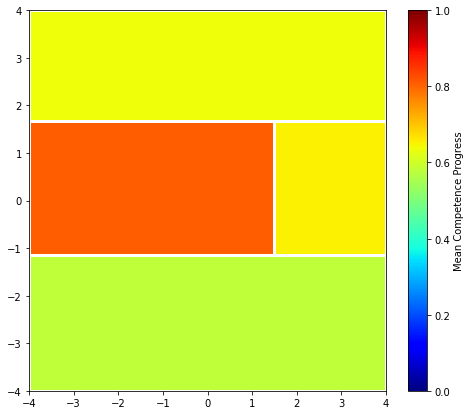

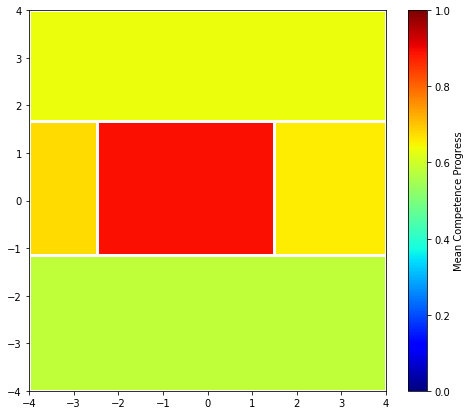

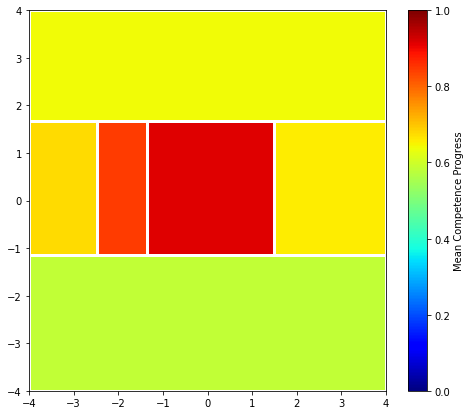

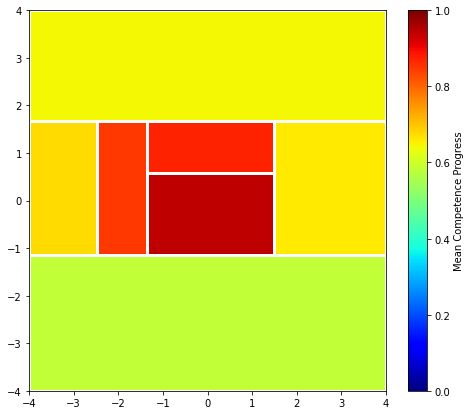

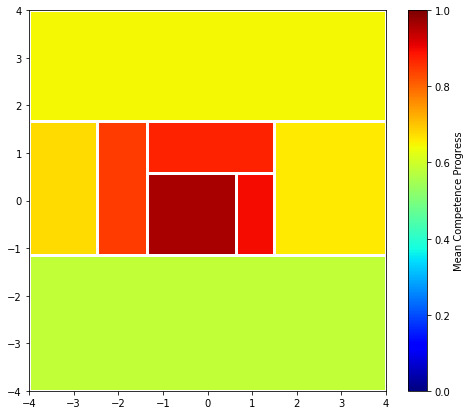

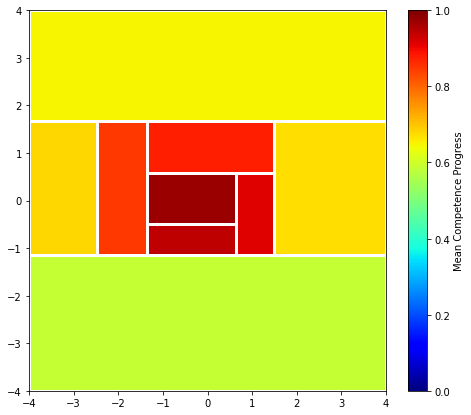

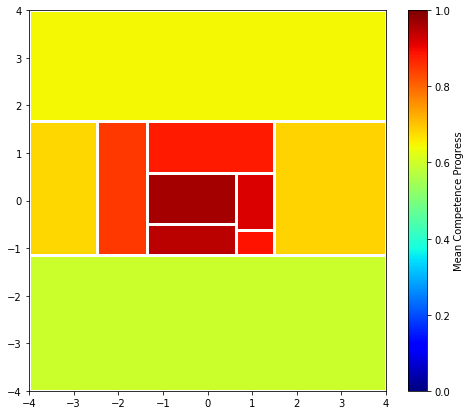

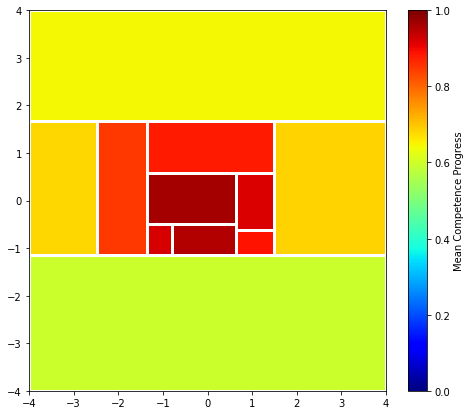

In [3]:
import copy
exploration_noise = 0.01
model_type = "random_flat"

# environment-related init
nb_arm_joints = 7
b = conf.get_env_bounds('armball_env')
# define variable's bounds for policy input and outcome
state_names = ['arm_x','arm_y']

nb_traj_steps = 1 #endpoint

# init neural network policy
input_names = state_names
input_bounds = b.get_bounds(input_names)
input_size = len(input_bounds)
print('input_bounds: %s' % input_bounds)
layers = [64]
action_set_size = 7#3
params = {'layers': layers, 'activation_function':'relu', 'max_a':1.,
          'dims':{'s':input_size,'a':action_set_size},'bias':True, 'size_sequential_nn':1}
nn = PolicyNN(params)
total_policy_params = get_n_params(nn)

# init IMGEP
full_outcome = input_names
objects, objects_idx = conf.get_objects('armball_env')
full_outcome = []
for obj in objects:
    full_outcome += obj * nb_traj_steps
full_outcome_bounds = b.get_bounds(full_outcome)

if (model_type == "random_flat") or (model_type == "random"):
    outcome1 = full_outcome
    config = {'policy_nb_dims': total_policy_params,
              'modules': {'mod1': {'outcome_range': np.arange(0,len(full_outcome),1),
                                   'focus_state_range': np.arange(0,len(full_outcome),1)//nb_traj_steps}}}
else:
    raise NotImplementedError
print(config)

seed = np.random.randint(1000)
np.random.seed(seed)
gep = GEP(layers, params, config, model_babbling_mode="random", explo_noise=exploration_noise, random_motor=0.0,
         goal_sampling='active')

starting_iteration = 0

env = gym.make('ArmBall-v0')
env.reset()
starting_iteration = 0
max_iterations = 500
reached_Xs = []
reached_Ys = []
outs = []
scaled_outs = []
goals = []
test_outs = []
test_goals = []
test_comp = []
nb_test_goals = 100
nb_bootstrap = 5

all_boxes = []
interests = []
iterations = []
plot = True
if plot:
    f, axlp = plt.subplots(1,1,figsize=(7,7))
test_goal_vec = [scale_vector(np.random.random(2) * 2 - 1,np.array(full_outcome_bounds)) for i in range(nb_test_goals)]
for i in range(starting_iteration, max_iterations):
    if ((i % 500) == 0): print("########### Iteration # %s ##########" % (i))
    # generate policy using gep
    policy_params, focus, add_noise, goal = gep.produce(bootstrap=True) if i < nb_bootstrap else gep.produce()
    if add_noise:
        policy_params[0] += np.random.normal(0, exploration_noise, len(policy_params[0]))
        policy_params[0] = np.clip(policy_params[0], -1, 1)
    nn.set_parameters(policy_params[0])
    outcome = run_episode(nn)
    scaled_outcome = scale_vector(outcome, np.array(full_outcome_bounds))
    gep.perceive(scaled_outcome, policy_params)

    reached_Xs.append(outcome[0])
    reached_Ys.append(outcome[1])
    outs.append(outcome)
    scaled_outs
    if goal is not None:
        goals.append(unscale_vector(goal, np.array(full_outcome_bounds)))
    
    if i > nb_bootstrap:
        if gep.modules['mod1'].split:
            print("regions {} all_boxes: {}".format(gep.modules['mod1'].act_goal_sampling.region_bounds,
                                                    type(gep.modules['mod1'].act_goal_sampling.region_bounds)))
            all_boxes.append(copy.copy(gep.modules['mod1'].act_goal_sampling.region_bounds))
            
            interests.append(copy.copy(gep.modules['mod1'].act_goal_sampling.interest))
            iterations.append(i)
            if plot:
                #print("boxes".format(all_boxes[-1]))
                plot_regions(all_boxes[-1], interests[-1])
    
    if ((i %20) == 0): #test
        for goal in test_goal_vec:
            batch_tg = []
            batch_to = []
            batch_comp = []
            
            policy_params, focus, add_noise = gep.produce(normalized_goal=goal.tolist(), goal_space_name='mod1')
            nn.set_parameters(policy_params[0])
            outcome = run_episode(nn)
            outcome = scale_vector(outcome, np.array(full_outcome_bounds))
            batch_tg.append(goal)
            batch_to.append(outcome)
            batch_comp.append(np.linalg.norm(goal - outcome) / len(outcome))
        
        test_goals.extend(batch_tg)
        test_outs.append(batch_to)
        test_comp.append(np.mean(batch_comp))
            
            

Populating the interactive namespace from numpy and matplotlib
[55, 87, 151, 173, 194, 217, 244, 258, 285, 324, 386, 467, 477]
500
495
[-1.15624905  1.18552017]
[-0.00273914 -0.31632865]


TypeError: list indices must be integers or slices, not NoneType

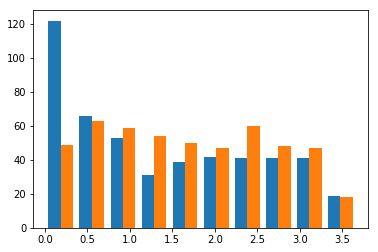

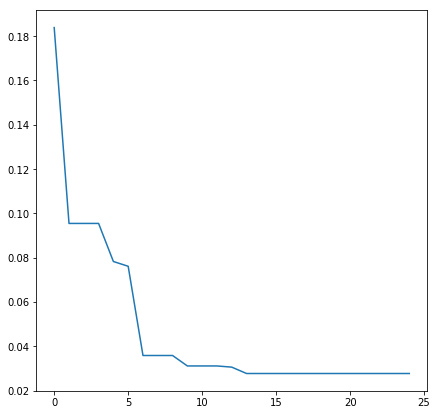

In [13]:
%pylab inline
#print(goals)
# LEARNING PROGRESS
train_errors = np.abs(np.array(goals) - np.array(outs[nb_bootstrap:]))
# print(full_outcome_bounds)
plt.hist(train_errors)
f, axlp = plt.subplots(1,1,figsize=(7,7))
axlp.plot(test_comp)
print(iterations)
print(len(reached_Xs))
print(len(goals))
#plot_density(np.array(goals)[:,0],np.array(goals)[:,1])
nb_bt = nb_bootstrap
#region_plot_gif()

#replay sagg_iac
ndims = 2
SAGG = SAGG_RIAC(np.array([-1.]*ndims), np.array([1.]*ndims))
for g,o in zip(np.array(goals),np.array(outs[nb_bootstrap:])):
    print(g)
    print(o)
    split, _ = SAGG.update([g], None, continuous_competence=[1 -(np.linalg.norm(g - o) / ndims)])
    if split:
        boxes = SAGG.region_bounds
        interest = SAGG.interest
        plot_regions(boxes, interest)
        plt.show()


![1](/home/remy/projects/spinningup/graphics/scatter.gif)

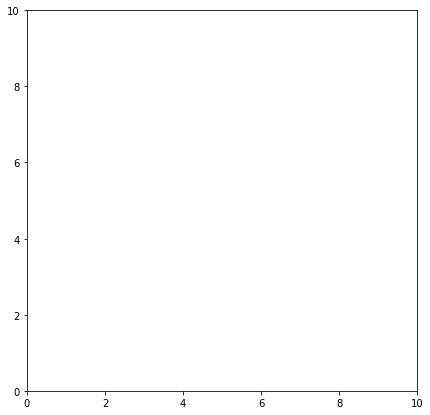

In [5]:
plt.ion()
f, ax = plt.subplots(1,1,figsize=(7,7))
ax.set_xlim(xmin=0,xmax=10)
ax.set_ylim(ymin=0,ymax=10)
a = np.arange(0,10,1)
for i in a:
    ax.plot(a[0:i])
    plt.pause(.001)
    plt.show()


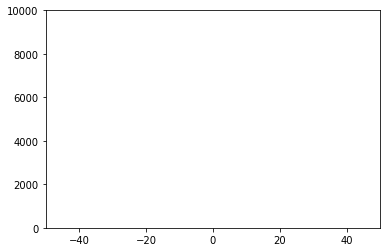

AttributeError: module 'matplotlib.pyplot' has no attribute 'clear'

In [6]:
def main():
    plt.axis([-50,50,0,10000])
    plt.ion()
    plt.show()

    x = np.arange(-50, 51)
    for pow in range(1,5):   # plot x^1, x^2, ..., x^4
        y = [Xi**pow for Xi in x]
        plt.clear()
        plt.plot(x, y)
        plt.draw()
        plt.pause(0.5)
main()